# BigARTM Python API.

BigARTM is an open library for topic modeling oftext collections. It's based on the ARTM theory. The projects main site
 is http://bigartm.org/.

The example of BigARTM Python API usage is showen below. We'll proceed a model experiment.

#### Description:
Let's learn two topic models of text collections, ARTM and PLSA, and compare them.

#### Quality measures:
One of the important measures is the perplexity. Nevertheless it's not the only way to chech the quality of the model learning. The following qualities are implemented in library:

- $\Phi$ (token-topic) matrix sparsity;
- $\Theta$ (topic-doc) matrix sparsity;
- topic kernel characteristics (purity, contrast, size);
- perplexity;
- coherency of top-tokens and tokens from topic kernels.

We'll use the first four ones. The higher values of sparsities and average purity and contrast means the more interpretable model.

#### Goals of the experiment:
We'll try to learn the ARTM model in the way to obtain better values of sparsities and kernel characteristics, than in PLSA, without significant decline of the perplexity.

The main tool to control the learning process is the regularization. Here's the list of currently implemented regularizers:

- $\Phi$ matrix sparsing (+ semi-supervised learning);
- $\Theta$ matrix sparsing (+ semi-supervised learning);
- $\Phi$ matrix topics decorrelation;
- forced $\Phi$ matrix sparsing;
- classes balancing (Label Regularization);
- coherency improving.

We'll use the first three regularizers in ARTM model in this experiment. ARTM without the regularization corresponds the PLSA model.

#### Text collection:
Let's use the small 'kos' collection from the UCI repository https://archive.ics.uci.edu/ml/machine-learning-databases/bag-of-words/. The collection has following parameters:

- 3430 documents;
- 6906 tokens in the dictionary;
- 467714 non-zero values in Bag-of-Words.

At first let's import all necessary modules (make sure you have the BigARTM Python API in your PATH variable):

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

First of all you need to prepare the input data. BigARTM has its own documents format for processing called batches. BigARTM has tools for their creation from Bag-of-Words UCI and Vowpal Wabbit formats (see more at http://docs.bigartm.org/en/latest/formats.html).

Library Python API similarly to scikit-learn algorithms represents input data in the form of one class called BatchVectorizer. This class object get batches or UCI / VW files as inputs and is used as input parameter in all methods. If the given data is not batches, the object will create them and store to disk.

So let's create the object of BatchVectorizer:

In [2]:
batch_vectorizer = None
if len(glob.glob(os.path.join('kos', '*.batch'))) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci', collection_name='kos', target_folder='kos')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos', data_format='batches')

ARTM is a class, that represents BigARTM Python API. Allows to use almost all library abilities in scikit-learn style. Let's create two topic models for our experiments. The most important parameter of the model is the number of topics. Optionally the user can define the list of regularizers and quality measures (scores) to be used in this model. This step can be done later. Note, that each model defines its own namespace for names of regularizers and scores.

In [3]:
model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(15)],
                  scores=[artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary')])

model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in xrange(15)],
                  scores=[artm.PerplexityScore(name='PerplexityScore',
                                               use_unigram_document_model=False,
                                               dictionary_name='dictionary')],
                  regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)])

The next step is to initialize models. It can be done using dictionary. It means:
- the $\Phi$ matrix with the name 'pwt' will be created with numbers of rows and columns corresponding the numbers of tokens in the dictionary and topics in the model;
- this matrix will be filled with random values from (0, 1) and normalized.

Note this step is optional: the model will be auto-initialized during the calls of fit_offline() / fit_online().

Dictionary is the object of BigARTM, containing the information about the collection (vocabulary, different counters and values, linked to tokens).

In [4]:
if not os.path.isfile('kos/dictionary.dict'):
    model_plsa.gather_dictionary('dictionary', batch_vectorizer.data_path)
    model_plsa.save_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary.dict')

model_plsa.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary.dict')
model_artm.load_dictionary(dictionary_name='dictionary', dictionary_path='kos/dictionary.dict')

Then dictionary can be used to initialize topic model:

In [5]:
model_plsa.initialize(dictionary_name='dictionary')
model_artm.initialize(dictionary_name='dictionary')

As it was said earlier, ARTM provides the ability to use all the scores of BigARTM. Once the score was included into model, the model will save all its values, obtained at the time of each $\Phi$ matrix update. Let's add the scores we need for our experiment (only ones, missed in the constructors):

In [6]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))

Now we'll do the same thing with the regularizers for artm_model (let's set their start coefficients of the regularization, these values can be changed later):

In [7]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

Now we'll try to learn the model in offline mode (e.g. with one $\Phi$ matrix update during one path through the whole collection). Let's start with 15 passes:

In [8]:
model_plsa.num_document_passes = 1
model_artm.num_document_passes = 1

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Let's check the results of first part of learning process by comparing the values of scores of both models:

Sparsity Phi: 0.022 (PLSA) vs. 0.605 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.406 (ARTM)
Kernel contrast: 0.523 (PLSA) vs. 0.550 (ARTM)
Kernel purity: 0.378 (PLSA) vs. 0.452 (ARTM)
Perplexity: 1510.214 (PLSA) vs. 1540.618 (ARTM)


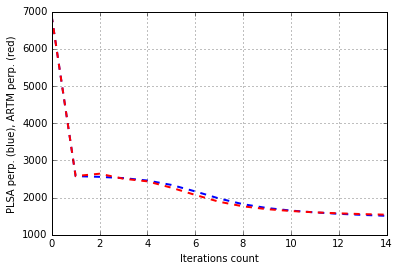

In [9]:
def print_measures(model_plsa, model_artm):
    print 'Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value)

    plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             xrange(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_artm)

We can see, that we have an improvement of sparsities and kernel measures, and the downgrade of the perplexion isn't big. Let's try to increase the absolute values of regularization coefficients:

In [10]:
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -0.2
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

Besides that let's include into each model the TopTokenScore measure, which allows to look at the most probable tokens in each topic:

In [11]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

We'll continue the learning process with 25 passes through the collection, and than will look at the values of the scores:

In [12]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Sparsity Phi: 0.332 (PLSA) vs. 0.721 (ARTM)
Sparsity Theta: 0.082 (PLSA) vs. 0.601 (ARTM)
Kernel contrast: 0.530 (PLSA) vs. 0.560 (ARTM)
Kernel purity: 0.396 (PLSA) vs. 0.504 (ARTM)
Perplexity: 1365.804 (PLSA) vs. 1464.752 (ARTM)


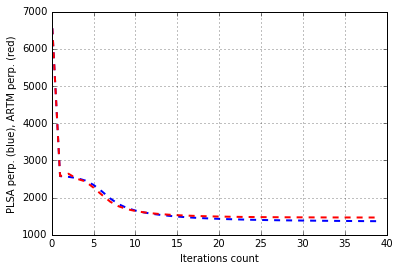

In [13]:
print_measures(model_plsa, model_artm)

Becides let's plot the changes of matrices sparsities by iterations:

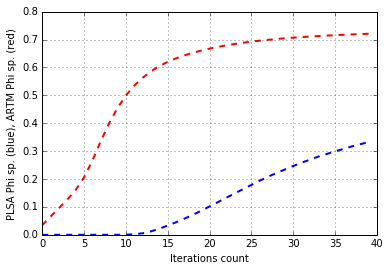

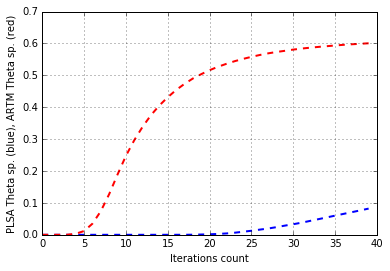

In [14]:
plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(xrange(model_plsa.num_phi_updates), model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
                 xrange(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

It seems that achieved result is enough. The regularization helped us to improve all scores with quite small perplexity downgrade. Let's look at top-tokens:

In [15]:
for topic_name in model_plsa.topic_names:
    print topic_name + ': ',
    print model_plsa.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

topic_0:  [u'bush', u'tax', u'states', u'president', u'party', u'political']
topic_1:  [u'iraq', u'war', u'military', u'troops', u'soldiers', u'iraqi']
topic_2:  [u'november', u'poll', u'house', u'governor', u'electoral', u'account']
topic_3:  [u'senate', u'republican', u'race', u'democrats', u'gop', u'republicans']
topic_4:  [u'time', u'people', u'general', u'election', u'speech', u'specter']
topic_5:  [u'dean', u'kerry', u'edwards', u'primary', u'clark', u'democratic']
topic_6:  [u'state', u'race', u'district', u'elections', u'candidate', u'party']
topic_7:  [u'administration', u'bush', u'years', u'president', u'jobs', u'marriage']
topic_8:  [u'campaign', u'dean', u'democratic', u'party', u'media', u'people']
topic_9:  [u'house', u'million', u'republican', u'money', u'delay', u'committee']
topic_10:  [u'november', u'voting', u'vote', u'kerry', u'republicans', u'electoral']
topic_11:  [u'iraq', u'bush', u'war', u'administration', u'president', u'intelligence']
topic_12:  [u'bush', u'p

In [16]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    print model_artm.score_tracker['TopTokensScore'].last_topic_info[topic_name].tokens

topic_0:  [u'party', u'tax', u'political', u'law', u'court', u'issue']
topic_1:  [u'military', u'troops', u'soldiers', u'killed', u'war', u'army']
topic_2:  [u'november', u'governor', u'poll', u'account', u'electoral', u'house']
topic_3:  [u'senate', u'republican', u'gop', u'republicans', u'senator', u'democrats']
topic_4:  [u'specter', u'speech', u'toomey', u'signs', u'time', u'message']
topic_5:  [u'dean', u'edwards', u'clark', u'primary', u'kerry', u'democratic']
topic_6:  [u'race', u'state', u'candidate', u'district', u'nader', u'candidates']
topic_7:  [u'administration', u'years', u'jobs', u'commission', u'president', u'white']
topic_8:  [u'campaign', u'media', u'democratic', u'unions', u'union', u'news']
topic_9:  [u'house', u'million', u'money', u'republican', u'delay', u'committee']
topic_10:  [u'november', u'vote', u'voting', u'electoral', u'account', u'governor']
topic_11:  [u'iraq', u'war', u'administration', u'bush', u'iraqi', u'american']
topic_12:  [u'bush', u'kerry', u'p

We can see, that topics are approximatelly equal in terms of interpretability, but they are more different in ARTM.

Let's extract the $\Phi$ matrix as pandas.DataFrame and print it (to do this operation with more options use ARTm.get_phi()):

In [17]:
print model_artm.phi_

                   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
parentheses       0.000000  0.000000  0.000000  0.000000  0.000000  0.000258   
opinion           0.000000  0.000226  0.000000  0.000000  0.000000  0.000000   
attitude          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
held              0.000571  0.000585  0.000154  0.000983  0.000000  0.000000   
impeachment       0.000000  0.000084  0.000000  0.000000  0.000000  0.000000   
platform          0.001414  0.000000  0.000000  0.000288  0.000000  0.000000   
msnbc             0.000000  0.000000  0.000000  0.000409  0.000000  0.000361   
assault           0.000000  0.000145  0.000000  0.000000  0.001514  0.000000   
tools             0.000229  0.000000  0.000000  0.000000  0.000548  0.000000   
vance             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
contingent        0.000000  0.000469  0.000000  0.000000  0.000000  0.000000   
drove             0.000000  0.000284  0.

We can store the model to disk with an ability to reload it:

In [18]:
model_artm.save(filename='kos_artm_model')  # save the model to disk

# model = artm.ARTM(...)                    # create new model
# model.load(filename='kos_artm_model')     # load saved model into new instance

Let's additionally extract $\Theta$ mtrix and print it:

In [19]:
theta_matrix = model_artm.get_theta()
print theta_matrix

              2001      2002      2003      2004      2005      2006  \
topic_0   0.066747  0.000000  0.000000  0.000000  0.000000  0.000000   
topic_1   0.000000  0.000000  0.000000  0.204690  0.000000  0.000000   
topic_2   0.000000  0.000000  0.000000  0.000000  0.000000  0.919343   
topic_3   0.007970  0.000000  0.000000  0.000000  0.000000  0.000000   
topic_4   0.000000  0.000000  0.000000  0.097521  0.000000  0.000000   
topic_5   0.101254  0.441901  0.690197  0.014904  0.634291  0.000000   
topic_6   0.013181  0.142726  0.000000  0.000000  0.092445  0.000000   
topic_7   0.000000  0.000000  0.000000  0.310020  0.000000  0.000000   
topic_8   0.077955  0.273763  0.309803  0.000000  0.000000  0.000000   
topic_9   0.666219  0.000000  0.000000  0.117660  0.000000  0.000000   
topic_10  0.015237  0.000000  0.000000  0.000000  0.000000  0.055730   
topic_11  0.000000  0.000000  0.000000  0.040025  0.000000  0.000000   
topic_12  0.051437  0.000000  0.000000  0.000000  0.273264  0.02

Можно использовать модель для определения векторов $\theta_d$ для новых документов с помощью метода ARTM.transform():

In [20]:
test_batch_vectorizer = artm.BatchVectorizer(data_format='batches', data_path='kos_test', batches=['test_docs.batch'])
test_theta_matrix = model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print test_theta_matrix

              3001      3002      3003      3004      3005      3006  \
topic_0   0.090061  0.052500  0.082226  0.113270  0.066424  0.013094   
topic_1   0.081177  0.042778  0.025247  0.033883  0.044768  0.020293   
topic_2   0.012976  0.042517  0.010438  0.031512  0.039660  0.328030   
topic_3   0.051793  0.039099  0.052948  0.097168  0.058483  0.030320   
topic_4   0.114853  0.066534  0.058967  0.057343  0.036550  0.015402   
topic_5   0.026519  0.027120  0.054451  0.053113  0.059482  0.021904   
topic_6   0.059681  0.045757  0.083296  0.067679  0.061700  0.025328   
topic_7   0.062243  0.074381  0.025125  0.046615  0.035011  0.012782   
topic_8   0.046812  0.036259  0.045797  0.087329  0.040499  0.015984   
topic_9   0.074736  0.375979  0.026324  0.141197  0.184587  0.034145   
topic_10  0.023609  0.027198  0.143750  0.041299  0.048756  0.359048   
topic_11  0.147780  0.050472  0.079082  0.057337  0.083605  0.012344   
topic_12  0.070624  0.048572  0.172403  0.087323  0.114977  0.05

#### Conclusion

Topic modeling task has an infinite set of solutions. It gives us a freedom in our choice. Regularizers give an opportunity to get the result, that satisfacts several criteria (such as sparsity, interpretability) at the same time.

Showen example is a demonstrative one, one can choose more flexible strategies of regularization to get better result. The experiments with other, bigger collection can be proceeded in the same way as it was described above.